# Image analysis with fMRI 3D images imported with LORIS API

This is a tutorial to show how to use Loris' API to download MRI images. It also contains a few examples of how the data can be used to run basic data analysis. 

This tutorial is also available as a Google colab notebook so you can run it directly from your browser. To access it, click on the button below: <a href="https://colab.research.google.com/github/spell00/Loris/blob/2020-08-06-JupyterCreateImageDataset/docs/notebooks/LORIS-API_Part3-Create_image_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Uncomment and run to install the packages required to run the notebook
# !pip3 install tqdm
# !pip3 install numpy
# !pip3 install nibabel
# !pip3 install sklearn
# !pip3 install matplotlib
# !pip3 install nilearn

## Setup

In [1]:
import getpass        # For input prompt not to show what is entered
import json           # Provide convenient functions to handle json objects 
import re             # For regular expression
import requests       # To handle http requests
import nibabel as nib
import numpy as np
import warnings
from tqdm import tqdm_notebook as tqdm  # To make a nice progress bar
import os
import itertools

os.chdir('..')

warnings.simplefilter('ignore') # Because I am using unverified ssl certificates 

def prettyPrint(string):
    print(json.dumps(string, indent=2, sort_keys=True))

In [21]:
import argparse
import torch
import torch.nn as nn
import numpy as np
import json
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter
from fmri.utils.activations import Swish, Mish
from fmri.utils.CycleAnnealScheduler import CycleScheduler
from fmri.utils.dataset import load_checkpoint, save_checkpoint, MRIDataset
from fmri.utils.transform_3d import Normalize, RandomRotation3D, ColorJitter3D, Flip90, Flip180, Flip270, XFlip, YFlip, \
    ZFlip
from fmri.models.supervised.MLP import MLP
from fmri.utils.plot_performance import plot_performance
import torchvision
from torchvision import transforms
from ax.service.managed_loop import optimize
import random
import nibabel as nib
from fmri.utils.utils import validation_spliter
import nilearn.plotting as nlplt


## Getting the data

The data on https://demo.loris.ca are only for development purposes. Nevertheless, with this in mind, we will use it for demonstration purposes only. In this tutorial, we will download all the T1 and T2 raw images from every project.

In [3]:
images_path = 'D:\\workbench\\projects\\AutoTKV_MouseMRI-master\\AllTrainingImages\\images\\'
targets_path = 'D:\\workbench\\projects\\AutoTKV_MouseMRI-master\\AllTrainingImages\\targets\\'

all_set = MRIDataset(images_path, targets_path, transform=None, resize=False)


In [10]:
spliter = validation_spliter(all_set, cv=5)
valid_set, train_set = spliter.__next__()


In [13]:
train_loader = DataLoader(train_set,
                          num_workers=0,
                          shuffle=True,
                          batch_size=1,
                          pin_memory=False,
                          drop_last=True)
valid_loader = DataLoader(valid_set,
                          num_workers=0,
                          shuffle=True,
                          batch_size=1,
                          pin_memory=False,
                          drop_last=True)


In [39]:
sample_x, sample_target = next(iter(valid_set))
sample_x = sample_x.numpy().squeeze()
sample_target = sample_target.numpy().squeeze()


In [45]:
np.round(sample.shape) / 2

array([  0.5, 128. , 128. ,  10. ])

In [46]:
def np_to_nifti(sample):
    coords = np.round(sample.shape) / 2
    t1_fullimage = nib.Nifti1Image(sample_x, np.eye(4))
    return nlplt.plot_anat(t1_fullimage, (128, 128, 10))


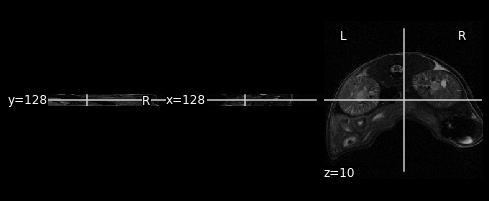

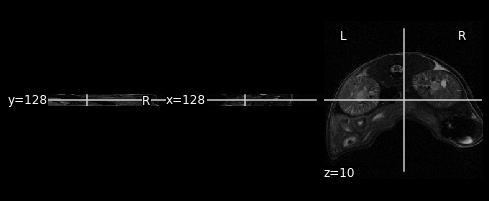

In [50]:
np_to_nifti(sample_x)
np_to_nifti(sample_target)


In [33]:
def _resize_data(data, new_size=(160, 160, 160)):
    initial_size_x = data.shape[0]
    initial_size_y = data.shape[1]
    initial_size_z = data.shape[2]

    new_size_x = new_size[0]
    new_size_y = new_size[1]
    new_size_z = new_size[2]

    delta_x = initial_size_x / new_size_x
    delta_y = initial_size_y / new_size_y
    delta_z = initial_size_z / new_size_z

    new_data = np.zeros((new_size_x, new_size_y, new_size_z))

    for x, y, z in itertools.product(range(new_size_x),
                                     range(new_size_y),
                                     range(new_size_z)):
        new_data[x][y][z] = data[int(x * delta_x)][int(y * delta_y)][int(z * delta_z)]

    return new_data



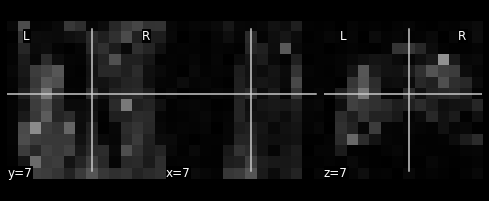

In [36]:
sample_x_14x14x14 = _resize_data(sample_x, (14, 14, 14))
t1_fullimage = nib.Nifti1Image(sample_x_14x14x14, np.eye(4))
nlplt.plot_anat(t1_fullimage, (7, 7, 7))
nlplt.show()


In [ ]:
training_images_dir = 'D:\workbench\projects\AutoTKV_MouseMRI-master\AllTrainingImages\images'

training_targets_dir = 'D:\workbench\projects\AutoTKV_MouseMRI-master\AllTrainingImages\targets'

#### Then, we get the information necessary to retrieve all images from all the projects and store them in a dictionnary.

In [ ]:
# The dictionary to store the images
images_dict = {
    "raw": {
        't1': [],
        't2': []
    },
    "32x32x32": {
        't1': [],
        't2': []
    },
    "128x128x128": {
        't1': [],
        't2': []
    }
}

In [ ]:
# Progress bar for downloads
pbar = tqdm(total=sum([len([meta for meta in imagesMeta[p]['Images'] if meta['ScanType'] in ['t1', 't2']]) for p in projectnames]))

for project in projectnames:
    for i, meta in enumerate(imagesMeta[project]['Images']):
        if(meta['ScanType'] not in ['t1', 't2']):
            continue
        r = requests.get(baseurl + meta['Link'], 
                     headers = {'Authorization': 'Bearer %s' % token})
        page = r.content
        filename = meta['Link'].split('/')[-1]
        t = meta['ScanType']

        # The images need to be saved first.
        # Only t1 and t2 images are kept. 
        if (t in ['t1', 't2']):
            file_ = open(filename, 'wb')
        else:
            continue
        file_.write(page)
        file_.close()
        img = nib.load(filename)

        # The images are not necessary for the rest of this tutorial.
        os.remove(filename) 

        img = img.get_fdata()

        # The images are save in the dictionary
        if(meta['ScanType'] == 't1'):
            images_dict["raw"]["t1"] += [img]
        if(meta['ScanType'] == 't2'):
            images_dict["raw"]["t2"] += [img]
        pbar.update(1)



## Preprocessing

In this section, we'll explore a few preprocessing methods that might make the models learned perform better.

### Resize images

In this tutorial, T1 and T2 images are compared. They are of similar sizes (160x256x224 and 160x256x256 for T1 and T2, respectively), but they need to be exactly the same size for any subsequent analysis.

In machine learning, it is common practice to reduce large images before training a model. Large images have the advantage of containing more information, but it comes with a tradeoff known as the Curse of dimensionality. Having a high dimensionality can make it much easier to have good performances on the training set, but the models trained overfit more easily to the training data and perform poorly on the validation and test data.

Of course, reducing images too much will also harm the performance of the model trained. There is no rule of thumb or algorithm to get the optimal size of images to be used in a specific task, so it might be a good idea to try a few different reductions.

This tutorial will explore 2 dimensions. Both will cubes (all sides have the same length): 128x128x128 and 32x32x32. The later dimensions might be a huge reduction, but the 3D images still have 32,768 dimensions (each voxel being a dimension), which is still huge, but much more manageable than the larger reduction, which has 2,097,152 dimensions. In order to decide which reduction to use, we will observe the data using a Principal Component Analysis (PCA). It will give an idea of whether the data has lost too much information to use it in a classification task. 

Ultimately, it might be necessary to use both strategies to test if one is better than the other. In case both strategies appear to be equal, Ockham's razor principle suggest the images with fewer voxels should be used. In this case, the notion of equality is somewhat arbitrary and might depend on the task to be accomplished.

In [ ]:
def resize_image(image, new_size=(160, 160, 160)):
    """
    Function to resize an image.
    Args:
        image (Numpy array of shape (Length, Width, Depth)): image to transform
        new_size (3-Tuple) : The new image length, width and Depth
    
    """

    initial_size_x = image.shape[0]
    initial_size_y = image.shape[1]
    initial_size_z = image.shape[2]

    new_size_x = new_size[0]
    new_size_y = new_size[1]
    new_size_z = new_size[2]

    delta_x = initial_size_x / new_size_x
    delta_y = initial_size_y / new_size_y
    delta_z = initial_size_z / new_size_z

    new_image = np.zeros((new_size_x, new_size_y, new_size_z))

    for x, y, z in itertools.product(range(new_size_x),
                                     range(new_size_y),
                                     range(new_size_z)):
        new_image[x][y][z] = image[int(x * delta_x)][int(y * delta_y)][int(z * delta_z)]

    return new_image



We need to create new directeories to save the resized T1 and T2 images.

#### Resize and normalize all T1 images

In [ ]:
from sklearn.preprocessing import Normalizer
pbar = tqdm(total=len(images_dict['raw']['t1']))

for t1 in images_dict['raw']["t1"]:
    t1_32 = resize_image(t1, (32, 32, 32))
    t1_32 = Normalizer().fit_transform(t1_32.reshape([1, -1]))
    t1_32 = t1_32.reshape([-1, 32, 32, 32])
    images_dict['32x32x32']['t1'] += [t1_32]

    t1_128 = resize_image(t1, (128, 128, 128))
    t1_128 = Normalizer().fit_transform(t1_128.reshape([1, -1]))
    t1_128 = t1_128.reshape([-1, 128, 128, 128])
    images_dict['128x128x128']['t1'] += [t1_128]

    pbar.update(1)

    """
    We don't need to save the images for this tutorial, but the package nibabel
    can be used to save the images to disk like this:

    img = nib.Nifti1Image(image_to_save, np.eye(4))
    img.to_filename("/path/to/new_file_name.nii")
    
    """

# Make numpy arrays from the lists of numpy arrays
images_dict['32x32x32']['t1'] = np.stack(images_dict['32x32x32']['t1'])
images_dict['128x128x128']['t1'] = np.stack(images_dict['128x128x128']['t1'])


#### Resize and normalize T2 images

In [ ]:
pbar = tqdm(total=len(images_dict['raw']['t2']))

for t2 in images_dict['raw']["t2"]:
    t2_32 = resize_image(t2, (32, 32, 32))
    t2_32 = Normalizer().fit_transform(t2_32.reshape([1, -1]))
    t2_32 = t2_32.reshape([-1, 32, 32, 32])
    images_dict['32x32x32']['t2'] += [t2_32]

    t2_128 = resize_image(t2, (128, 128, 128))
    t2_128 = Normalizer().fit_transform(t2_128.reshape([1, -1]))
    t2_128 = t2_128.reshape([-1, 128, 128, 128])
    images_dict['128x128x128']['t2'] += [t2_128]

    pbar.update(1)

# Make numpy arrays from the lists of numpy arrays
images_dict['32x32x32']['t2'] = np.stack(images_dict['32x32x32']['t2'])
images_dict['128x128x128']['t2'] = np.stack(images_dict['128x128x128']['t2'])


### Visualisation with nilearn

Visualisation of the raw images and the 2 reductions for T1 and T2 images.

#### T1 images

In [ ]:
# This package is used to plot a section of the 3D images
import nilearn.plotting as nlplt  

print("Original (160x256x224)")
t1_fullimage = nib.Nifti1Image(images_dict['raw']['t1'][0], np.eye(4))
nlplt.plot_anat(t1_fullimage, (80, 128, 112))
nlplt.show()

print("128x128x128")
img_t1_128 = nib.Nifti1Image(resize_image(images_dict['raw']['t1'][0], (128, 128, 128)), np.eye(4))
nlplt.plot_anat(img_t1_128, (64, 64, 64))
nlplt.show()

print("32x32x32")
img_t1_32 = nib.Nifti1Image(resize_image(images_dict['raw']['t1'][0], (32, 32, 32)), np.eye(4))
nlplt.plot_anat(img_t1_32, (16, 16, 16))
nlplt.show()

#### T2 images

In [ ]:
print("Original (160x256x256)")
t2_fullimage = nib.Nifti1Image(images_dict['raw']['t2'][0], np.eye(4))
nlplt.plot_anat(t2_fullimage, (80, 128, 112))
nlplt.show()

print("128x128x128")
img_t2_128 = nib.Nifti1Image(resize_image(images_dict['raw']['t2'][0], (128, 128, 128)), np.eye(4))
nlplt.plot_anat(img_t2_128, (64, 64, 64))
nlplt.show()

print("32x32x32")
img_t2_32 = nib.Nifti1Image(resize_image(images_dict['raw']['t2'][0], (32, 32, 32)), np.eye(4))
nlplt.plot_anat(img_t2_32, (16, 16, 16))
nlplt.show()

## Unsupervised learning: Principal Component Analysis

Principal Component Analysis (PCA) is a popular method used for dimensioanlity reduction, which is a good first step to vizualise the data to analyse and can give insight for the subsequent steps of the analysis. Dimensionality reduction can also be used to transform the data before using it to train a ML model.

In [ ]:
# sklearn needs the data to be flattened
images_dict['32x32x32']['t1'] = images_dict['32x32x32']['t1'].reshape(
    [images_dict['32x32x32']['t1'].shape[0], -1]
)
images_dict['128x128x128']['t1'] = images_dict['128x128x128']['t1'].reshape(
    [images_dict['128x128x128']['t1'].shape[0], -1]
)

images_dict['32x32x32']['t2'] = images_dict['32x32x32']['t2'].reshape(
    [images_dict['32x32x32']['t2'].shape[0], -1]
)
images_dict['128x128x128']['t2'] = images_dict['128x128x128']['t2'].reshape(
    [images_dict['128x128x128']['t2'].shape[0], -1]
)

In [ ]:
#@title The orginal T1 images have a total of 9175040 voxels. 
from IPython.display import Markdown as md
md("The sizes for the  32x32x32 and 128x128x128 images are \
{} and {}, respectively. They represent {}% and \
{}% of the original size.".format(images_dict['32x32x32']['t1'].shape[1], 
                                  images_dict['128x128x128']['t1'].shape[1],
                                  np.round(images_dict['32x32x32']['t1'].shape[1] / 9175040 * 100, 2),
                                  np.round(images_dict['128x128x128']['t1'].shape[1] / 9175040 * 100, 2),
                                  )
)


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
pca32 = PCA(n_components=2)
pca32.fit(
    np.concatenate([
        images_dict['32x32x32']['t1'][:30],
        images_dict['32x32x32']['t2'][:30]
    ], 0)
)

# Some samples (usually ~10-20%) are used as validation data that will not 
# be used to train the model.
t1_transform_train = pca32.transform(images_dict['32x32x32']['t1'][:30])
t2_transform_train = pca32.transform(images_dict['32x32x32']['t2'][:30])
t1_transform_valid = pca32.transform(images_dict['32x32x32']['t1'][30:])
t2_transform_valid = pca32.transform(images_dict['32x32x32']['t2'][30:])

plt.figure(figsize=(12,6))

blues = ['b' for _ in range(len(images_dict['32x32x32']['t1'][:30]))]
greens = ['g' for _ in range(len(images_dict['32x32x32']['t2'][:30]))]
reds = ['r' for _ in range(len(images_dict['32x32x32']['t1'][30:]))]
cyans = ['c' for _ in range(len(images_dict['32x32x32']['t2'][30:]))]

blue_patch = mpatches.Patch(color='b', label='T1 (train)')
green_patch = mpatches.Patch(color='g', label='T2 (train)')
red_patch = mpatches.Patch(color='r', label='T1 (valid)')
cyan_patch = mpatches.Patch(color='c', label='T2 (valid)')

plt.scatter(t1_transform_train[:, 0], t1_transform_train[:, 1], c=blues)
plt.scatter(t2_transform_train[:, 0], t2_transform_train[:, 1], c=greens)
plt.scatter(t1_transform_valid[:, 0], t1_transform_valid[:, 1], c=reds)
plt.scatter(t2_transform_valid[:, 0], t2_transform_valid[:, 1], c=cyans)

plt.title('PCA of images resized to 32x32x32')
plt.legend()
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(handles=[blue_patch, green_patch, red_patch, cyan_patch])
plt.show()
plt.close()


pca128 = PCA(n_components=2)
pca128.fit(
    np.concatenate([
        images_dict['128x128x128']['t1'][:30],
        images_dict['128x128x128']['t2'][:30]
    ], 0)
)

t1_transform_train = pca128.transform(images_dict['128x128x128']['t1'][:30])
t2_transform_train = pca128.transform(images_dict['128x128x128']['t2'][:30])
t1_transform_valid = pca128.transform(images_dict['128x128x128']['t1'][30:])
t2_transform_valid = pca128.transform(images_dict['128x128x128']['t2'][30:])

plt.figure(figsize=(12,6))

plt.scatter(t1_transform_train[:, 0], t1_transform_train[:, 1], c=blues)
plt.scatter(t2_transform_train[:, 0], t2_transform_train[:, 1], c=greens)
plt.scatter(t1_transform_valid[:, 0], t1_transform_valid[:, 1], c=reds)
plt.scatter(t2_transform_valid[:, 0], t2_transform_valid[:, 1], c=cyans)

plt.title('PCA of images resized to 128x128x128')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.legend(handles=[blue_patch, green_patch, red_patch, cyan_patch])
plt.show()
plt.close()

In [ ]:
#@title The orginal T1 images have a total of 9175040 voxels. 
from IPython.display import Markdown as md
md("For the 128x128x128 voxel images, the first component of the PCA "
    "explains ~{}% of the variance of the images and the second ~{}%. "
    "For the 32x32x32 images, the first component explains {}% of the "
    "variance and the second {}%".format(
        np.round(pca128.explained_variance_ratio_[0] * 100, 2),
        np.round(pca128.explained_variance_ratio_[1] * 100, 2),
        np.round(pca32.explained_variance_ratio_[0] * 100, 2),
        np.round(pca32.explained_variance_ratio_[1] * 100, 2),
))

## Basic machine learning classification model

The classification in this tutorial is trivial, so a simple linear model like a logistic regression classifier should be able to learn hot to perfectly classify the images for both image sizes.



In [ ]:
from sklearn.linear_model import LogisticRegression

print('32x32x32')

lr32 = LogisticRegression()
labels = [0 for x in range(len(images_dict['32x32x32']['t1'][:30]))] + \
         [1 for x in range(len(images_dict['32x32x32']['t2'][:30]))]
labels_valid = [0 for x in range(len(images_dict['32x32x32']['t1'][30:]))] + \
               [1 for x in range(len(images_dict['32x32x32']['t2'][30:]))]
lr32.fit(
    np.concatenate([
        images_dict['32x32x32']['t1'][:30],
        images_dict['32x32x32']['t2'][:30]
    ], 0),
    labels
)

# Labels T1 are 0s and T2 are 1
labels_t1_train = [0 for _ in preds_t1]
labels_t1_valid = [0 for _ in preds_t1_valid]
labels_t2_train = [1 for _ in preds_t2]
labels_t2_valid = [1 for _ in preds_t2_valid]

preds_t1 = lr32.predict(images_dict['32x32x32']['t1'][:30])
preds_t2 = lr32.predict(images_dict['32x32x32']['t2'][:30])
preds_t1_valid = lr32.predict(images_dict['32x32x32']['t1'][30:])
preds_t2_valid = lr32.predict(images_dict['32x32x32']['t2'][30:])

accuracy = sum([1 if pred == target else 0 for (pred, target) in zip(
    np.concatenate((preds_t1_train, preds_t2_train)),
    np.concatenate((labels_t1_train, labels_t2_train)))]
) / len(labels)

accuracy_valid = sum([1 if pred == target else 0 for (pred, target) in zip(
    np.concatenate((preds_t1_valid, preds_t2_valid)),
    np.concatenate((labels_t1_valid, labels_t2_valid)))]
) / len(labels_valid)

print('Train Accuracy: ', accuracy)
print('Valid Accuracy: ', accuracy_valid)

print('128x128x128')

lr128 = LogisticRegression()
labels = [0 for x in range(len(images_dict['128x128x128']['t1'][:30]))] + \
         [1 for x in range(len(images_dict['128x128x128']['t2'][:30]))]
labels_valid = [0 for x in range(len(images_dict['128x128x128']['t1'][30:]))] + \
               [1 for x in range(len(images_dict['32x32x32']['t2'][30:]))]

lr128.fit(
    np.concatenate([
        images_dict['128x128x128']['t1'][:30],
        images_dict['128x128x128']['t2'][:30]
    ], 0),
    labels
)


preds_t1_train = lr128.predict(images_dict['128x128x128']['t1'][:30])
preds_t2_train = lr128.predict(images_dict['128x128x128']['t2'][:30])
preds_t1_valid = lr128.predict(images_dict['128x128x128']['t1'][30:])
preds_t2_valid = lr128.predict(images_dict['128x128x128']['t2'][30:])
accuracy = sum([1 if pred == target else 0 for (pred, target) in zip(
    np.concatenate((preds_t1_train, preds_t2_train)),
     np.concatenate((labels_t1_train, labels_t2_train)))]
) / len(labels)
accuracy_valid = sum([1 if pred == target else 0 for (pred, target) in zip(
    np.concatenate((preds_t1_valid, preds_t2_valid)), 
    np.concatenate((labels_t1_valid, labels_t2_valid)))]
) / len(labels_valid)

print('Train Accuracy: ', accuracy)
print('Valid Accuracy: ', accuracy_valid)